In [17]:
! pip install pytorch-lightning

In [18]:
%matplotlib inline
import pytorch_lightning as pl
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data Module

In [19]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir='data', batch_size=64, num_workers=0):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transforms.Compose([transforms.Resize(64), 
                                             transforms.ToTensor()])

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)

    def setup(self, stage=None):
        mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
        self.mnist_train = mnist_full

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

# GAN Model

## Discriminator

In [20]:
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim

class Discriminator(nn.Module):
    def __init__(self, in_channels, n_features, out_channels):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=n_features, kernel_size=4, stride=2, padding=1)    #32x32
        self.batchnorm1 = nn.BatchNorm2d(num_features=n_features)
        self.conv2 = nn.Conv2d(in_channels=n_features, out_channels=n_features*2, kernel_size=4, stride=2, padding=1) #16x16
        self.batchnorm2 = nn.BatchNorm2d(num_features=n_features*2)
        self.conv3 = nn.Conv2d(in_channels=n_features*2, out_channels=n_features*4, kernel_size=4, stride=2, padding=1) #8x8
        self.batchnorm3 = nn.BatchNorm2d(num_features=n_features*4)
        self.conv4 = nn.Conv2d(in_channels=n_features*4, out_channels=n_features*8, kernel_size=4, stride=2, padding=1) #4x4
        self.batchnorm4 = nn.BatchNorm2d(num_features=n_features*8)

        self.conv5 = nn.Conv2d(in_channels=n_features*8, out_channels=out_channels, kernel_size=4, stride=1, padding=0) #1x1
        
    def forward(self, x):

        # conv2d -> batchnorm2d -> leakyrelu -> conv2d...
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = func.leaky_relu(x, 0.2)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = func.leaky_relu(x, 0.2)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = func.leaky_relu(x, 0.2)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = func.leaky_relu(x, 0.2)

        out = self.conv5(x)
        
        return out

## Generator

In [21]:
class Generator(nn.Module):
    def __init__(self, in_channels, n_features, out_channels):
        super(Generator, self).__init__()
        # project and reshape z
        self.convT1 = nn.ConvTranspose2d(in_channels=in_channels, out_channels=n_features*16, kernel_size=4, stride=1, padding=0) # 4x4
        self.batchnorm1 = nn.BatchNorm2d(num_features=n_features*16)
        
        self.convT2 = nn.ConvTranspose2d(in_channels=n_features*16, out_channels=n_features*8, kernel_size=4, stride=2, padding=1) # 8x8
        self.batchnorm2 = nn.BatchNorm2d(num_features=n_features*8)
        self.convT3 = nn.ConvTranspose2d(in_channels=n_features*8, out_channels=n_features*4, kernel_size=4, stride=2, padding=1)  # 16x16
        self.batchnorm3 = nn.BatchNorm2d(num_features=n_features*4)
        self.convT4 = nn.ConvTranspose2d(in_channels=n_features*4, out_channels=n_features*2, kernel_size=4, stride=2, padding=1)  # 32x32
        self.batchnorm4 = nn.BatchNorm2d(num_features=n_features*2)

        self.convT5 = nn.ConvTranspose2d(in_channels=n_features*2, out_channels=out_channels, kernel_size=4, stride=2, padding=1) # 64x64
        


    def forward(self, x):
        # conv2d -> batchnorm2d -> relu -> conv2d...
        x = self.convT1(x)
        x = self.batchnorm1(x)
        x = func.relu(x)
        x = self.convT2(x)
        x = self.batchnorm2(x)
        x = func.relu(x)
        x = self.convT3(x)
        x = self.batchnorm3(x)
        x = func.relu(x)
        x = self.convT4(x)
        x = self.batchnorm4(x)
        x = func.relu(x)
     
        # output
        out = func.tanh(self.convT5(x))
        
        return out

## GAN

In [22]:
criterion = nn.BCEWithLogitsLoss()
samples = []
losses = []


class GAN(pl.LightningModule):
    def __init__(self, 
                 img_channel: int = 1,
                 z_size: int = 100, 
                 n_features: int = 64, 
                 lr: float = 0.0002, 
                 **kwargs):
        super().__init__()
        self.save_hyperparameters()

        self.generator = Generator(in_channels=z_size, n_features=n_features, out_channels=img_channel).to(device)
        self.discriminator = Discriminator(in_channels=img_channel, n_features=n_features, out_channels=1).to(device)

        sample_size = 32
        self.fixed_z = torch.randn((sample_size, self.hparams.z_size, 1, 1)).to(device)

    def forward(self, z):
        return self.generator(z)

    def training_step(self, batch, batch_idx, optimizer_idx):
        real_imgs, _ = batch
        batch_size = real_imgs.shape[0]
        # rescale input images from [0,1) to [-1, 1)
        real_imgs = real_imgs*2 - 1

        z = torch.randn((batch_size, self.hparams.z_size, 1, 1)).to(device)

        # train discriminator
        if optimizer_idx == 1:

            # Train with real images
            real_labels = torch.ones(batch_size).to(device)
            real_labels = real_labels * 0.9

            d_out_real = self.discriminator(real_imgs)
            real_loss = criterion(d_out_real.squeeze(), real_labels)

            # Train with fake images
            fake_imgs = self.generator(z)
            fake_labels = torch.zeros(batch_size).to(device)

            d_out_fake = self.discriminator(fake_imgs)
            fake_loss = criterion(d_out_fake.squeeze(), fake_labels)

            # Add up loss
            d_loss = real_loss + fake_loss

            self.d_loss = d_loss.item()
            return d_loss

        # train generator
        if optimizer_idx == 0:

            # generate images
            fake_imgs = self.generator(z)

            real_labels = torch.ones(batch_size).to(device)
            real_labels = real_labels * 0.9

            D_out_fake = self.discriminator(fake_imgs)
            g_loss = criterion(D_out_fake.squeeze(), real_labels)   # flip labels

            self.g_loss = g_loss.item()
            return g_loss

    def configure_optimizers(self):
        lr = self.hparams.lr

        g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=lr)
        d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [g_optimizer, d_optimizer], []

    def on_epoch_end(self):
        
        losses.append((self.d_loss, self.g_loss))

        # log sampled images
        self.generator.eval()
        sample_imgs = self.generator(self.fixed_z)
        samples.append(sample_imgs)
        self.generator.train()

In [23]:
dm = MNISTDataModule()
model = GAN()
trainer = pl.Trainer(max_epochs=10, progress_bar_refresh_rate=20, gpus=1) 
trainer.fit(model, dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 12.7 M
1 | discriminator | Discriminator | 2.8 M 
------------------------------------------------
15.4 M    Trainable params
0         Non-trainable params
15.

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [24]:
import pickle as pkl
with open('DCGAN_pl_train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

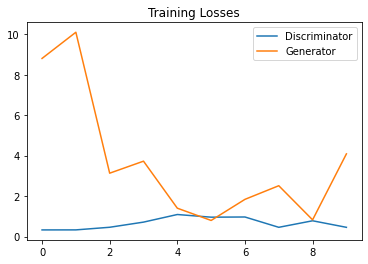

In [25]:
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

# Sample

## Training sample

In [26]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((64,64)), cmap='Greys_r')

In [27]:
# Load samples from generator, taken while training
with open('DCGAN_pl_train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

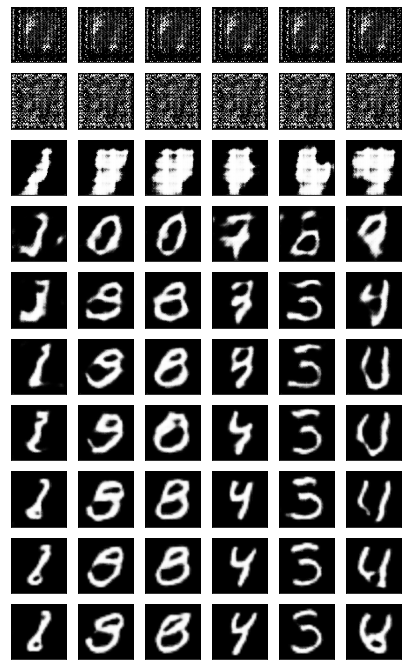

In [28]:
rows = 10 # show every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach().cpu()
        ax.imshow(img.reshape((64,64)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Result sample

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


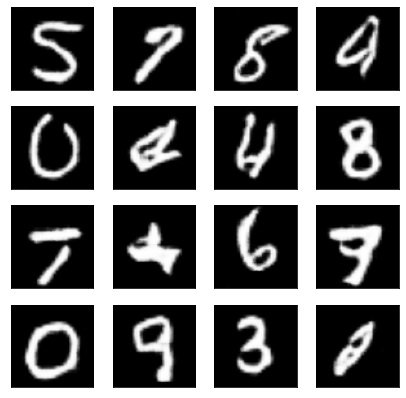

In [31]:
sample_size=16
rand_z = torch.randn((sample_size, model.hparams.z_size, 1, 1))

model.eval()
rand_images = model(rand_z)

view_samples(0, [rand_images])

In [36]:
# interpolation between two points in latent space
def interpolate(p1, p2, n_steps=10):
	ratios = np.linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	vectors = torch.cat(vectors).reshape(-1, model.hparams.z_size, 1, 1)
	return vectors

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


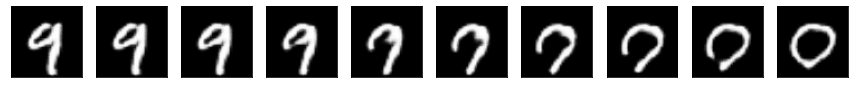

In [93]:
n_steps = 10
n_interpolate_samples = 2
z_input = torch.randn((n_interpolate_samples, model.hparams.z_size, 1, 1))

z_interpolate = interpolate(z_input[0], z_input[1], n_steps=n_steps)   # n_steps x z_size


interpolate_samples = model(z_interpolate)

fig, axes = plt.subplots(figsize=(15,15), nrows=1, ncols=10, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), interpolate_samples):
    img = img.detach().cpu()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((64,64)), cmap='Greys_r')